# Project 2

## Imports

In [6]:
%matplotlib inline
from IPython.display import Image
from IPython.core.display import display

## Historical data

### Structures in the data

#### Overview of the data

We could look at the simple distribution of the two symptoms. This shows the frequency of the two symptoms in the entire dataset. From the histogram it could seem like symptom 2 is less frequent than symptom 1.

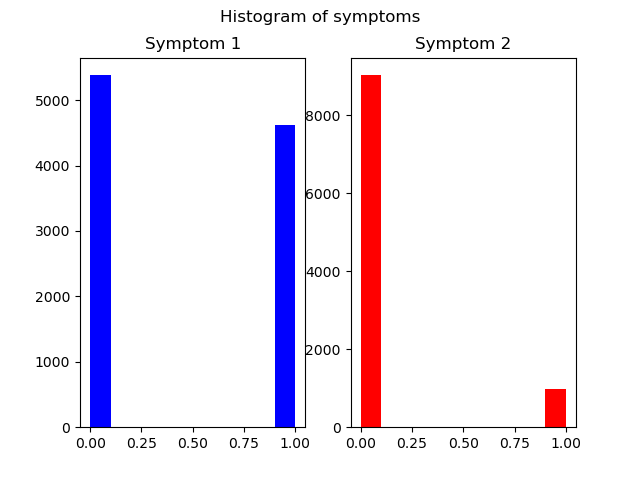

In [5]:
display(Image(filename="img/freq_hist.png", width = 600))

#### Single cause versus multiple cause model

Just by looking at the simple histogram of frequencies we see that the distribution of the two symptoms are very different. Symptom 2 seems to be far less frequent than symptom 1. In order to look further into into unknown clusters in the data, we could use unsupervised learning techniques such as K-means clustering or hierarchical clustering. Our overall goal is to predict the symptoms based on the covariates which are gender, smoker and gene expression data. Because of the number of covariates (the number of different gene expressions), it is not trivial to examine if there is a single cause (covariate) for the symptoms or not.

There could also be a subset of gene expression that are the main cause of the symptoms, but determining which of the gene expression that explains the most of the variability in the symptoms could be more difficult to infer. This is closely related to the concept of confounding covariates. Two covariates, if correlated, could be subject to confounding in such a way that the effect of the second covariate could be partly expressed through the first covariate. In the case of two covariates, the second is then affecting through $\hat{\rho} \sqrt{\frac{\sigma_{1}}{\sigma_{2}}}$ where $\hat{\rho}$ is the correlation between the covariates, $\sigma_i$ is the standard deviation of the covariate $i$ (Borgan, 2019, p. 1). In our case this could be the case if we include some number of genes as covariates. Some genes could be confounded by other genes, masking their influence on the response variable.

By attempting to narrow down the covariates that cause a particular symptom, we are looking at a "causes of effect" problem (Dawid, 2015, p. 5). That is, what covariates causes the symptoms observed in the data set. When it comes to data sets that we observe after the "experiment" has taken place (that is, collecting the data) there should ideally be exchangeability among the observations (Dawid, 2015, p. 21). This condition may be difficult to verify when looking at the dataset, especially when taking into account the uncertainty that (may) be involved when registering data for the symptoms. These could range from objective measurese such as a level of concentration or to more subjective measures such as an individual assessment of symptoms.

Further, Dawid also discusses the negative impact of confounding when observing the data. In order to achieve this, there must in principal be exchangeability between groups within the data. He then considers the case of having the treated groups being exchangeable with the non-treated group in order to have exchangeability and that this in theory happens when the observations are randomised (Dawid, 2015, pp. 21-22). Dawid then relates the absence of confounding to independence between the covariates (Dawid, 2015, p. 22). This can also be considered when looking at the definition from Borgan above, where confounding is expressed through correlation $\hat{\rho}$ between the covariates.

##### K-means clustering

The idea behind K-means clustering is to find the clusters that minimize the variation within each of the clusters. The distance between two observations could then be measured as the squared euclidean distance between the $C$ covariates of the two observations

$$
\sum_{j=1}^{C} (x_{ij} - x_{i'j})^{2}
$$

adapted from (James et al., 2013, p. 387). Further, we then want to minimize the following equation in order to obtain the "optimal" clusters where $G_{k}$ is one of the $K$ clusters and we sum the squared euclidean distance between points within the same cluster $G_{k}$

$$
\sum_{k=1}^{K} \frac{1}{|G_{k}|} \sum_{i \cap i' \in G_{k}} \sum_{j=1}^{C} (x_{ij} - x_{i'j})^{2}
$$

adapted from (James et al., 2013, p. 387).

The algorithm then computes the "mean" observation for each cluster which in fact is the mean of all the covariates within the cluster. Then the observations are placed in the clusters in which they are closest to measured in for example squared euclidean distance (James et al., 2013, p. 388).

In this example, we could use this algorithm with $K=2$ and check the clusters created by the algorithm with the different symptoms. Intuitively, if a large percentage of the cluster 1 observations exhibit one of the symptoms compared to those observations in cluster 2 it could be reason to investigate closer if there in fact are two different clusters of observations, each mainly related to each of the symptoms. Unfortunately, the K-means clustering will be difficult to perform due to the binary structure of the data.

##### Logistic regression

I will instead look into logistic regression as a model for the data. There could be defined a model for each of the covariates and all combinations of covariates up to the full model with all the covariates. First, I want to try using cross-validation on a valdiation set (within the training data) in order to select the covariates that make up the "best" model when it comes to prediction. In that way, I could say that it is more likely that there is a single-cause model if the best model w.r.t. prediction is a model with a single covariate. On the other hand, if the number of "optimally" chosen covariates are $>1$ then this could imply that there is in fact a multiple-cause model that is more likely. It would also have been possible to use different forms of information criterias in order to perform variable selection, such as AIC or BIC. This would have penalized the number of covariates directly to avoid overfitting. An alternative to this is cross-validation on the training data where the cross-validation error is the misclassification rate. This is then measured on the validation set as described below.

In order to check the effect of the different covariates, I used recursive feature elimination with cross-validation in order to select the covariates based on the misclassification score (scikit learn, 2020). This is then specified to use a stratified K-fold cross-validation (because of the few occurences of symptom 2). What is interesting is the fact that for both symptoms, the variable selection selects one covariate for each symptom, 'gene 4' for symptom 1 and 'gene 3' for symptom 2 based on 3-fold cross-validation on the training data of the dataset. Looking at the accuracy score for the logistic regression of the two symptoms

##### Hierarchical model

The relationship we are interested in is given by $y_t | a_t$, that is, how is the outcome for the observation dependent on the intervention ($a_t$). Before we can do this, we would like to consider the causes for the symptoms $x_{129}$ and $x_{130}$. This can be considered as a hierachical model in the Bayesian framework. If we look at a model posterior, we have

$$
\phi (\mu_i | \vec{y}) = \frac{P(\vec{y} | \mu_i) \phi (\mu_i)}{\sum_{i} P(\vec{y} | \mu_i) \phi (\mu_i)}
$$

for a model $\mu_i$, adapted from (Dimitrakakis, 2020, p. 98). The problem we then have is to specify a prior for the different models, this could for example be a noninformative prior (e.g. uniform) if we have no specific information to suggest otherwise prior to selecting the models. For simplicity, we define the single-cause models as having one covariate and the multiple-cause model as having all the covariates. In our case, we then have 129 different models for each of the symptoms. If we consider the different models as being different logistic regression using the different covariates we could define the structure

$$
y_t \sim Bernoulli(\eta_t)
$$

and 

$$
\eta_t(\vec{x}_t) = \beta_0 + \vec{\beta}^{T}\vec{x}
$$

after calculating the model, we would then have $P(\vec{y} | \mu_i)$, the likelihood of the observed data given the model $\mu_i$.

Obviously, we do not know $\phi(\mu_i)$, so we use a subjective probability distribution $\xi$ (Dimitrakakis, 2020, p. 108) as an estimator of the true (unknown) $\phi$.

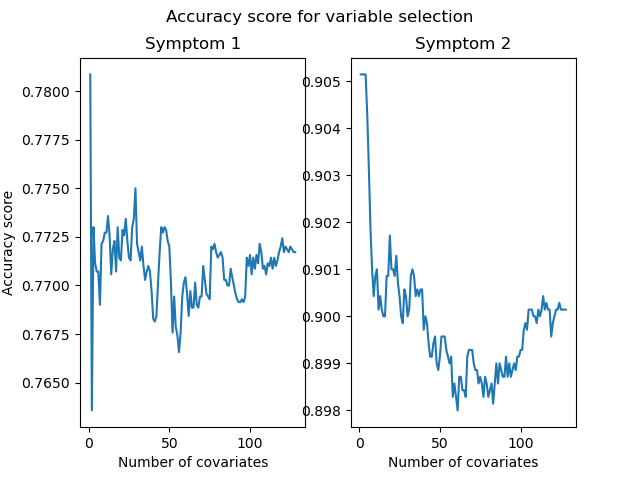

In [4]:
display(Image(filename="img/var_sel.png", width = 600))

#### Factors that may be important for disease epidemiology

Based on the variable selection using stratified cross-validation and logistic regression above it could be important to look further into the gene expression that were selected using the variable selection above for the different symptoms. Since the predictive ability of the model seems to be best (on the validation set within the cross-validation) it implies that these genes should be further investigated. This could point toward there being a single-cause model and intuitively, if the data of the selected genes could be measured more accurately/effectively, this could be important for disease epidemiology.

In an ideal world, we would know if we found a sufficient covariate for the outcome $y_t$. This would imply that the outcome would be conditionally independent of the policy given this covariate and the action $a_t$ (Dimitrakakis, 2020, pp. 137-138). Intuitively, if we knew that for example 'gene 3' was the sufficient covariate, we would need only to check this covariate for the different observations. 

More likely is maybe the case where one of the covariates found above is an instrumental variable? In this case, the instrumental variable is a "representation" of the underlying/latent variable that affects both the outcome $y_t$ and the action $a_t$ (Dimitrakakis, 2020, p. 138). If this instrumental variable is possible to measure it could still function as a proxy for the sufficient variable (which may be unobservable).

### Measuring the effect of actions

We now need to look into the action $a$ and the outcome $y$ followed by this action. Intuitively, what we would like to measure is $y_t | a_t$, that is, the outcome given the different actions (in this case therapeutic intervention). If we define $y_t = 1$ to be a positive outcome (positive outcome) and $y_t = 0$ a negative outcome (no effect of action). Then we could define $a_t = 0$ to be placebo (no intervention) and $a_t = 1$ to be the intervention/medication.

When looking at the outcome variable $y_t$ we could think of this as a Bernoulli distributed variable when $a_t$ is given. We could then look at the estimator for the utility of a policy given an action $a_t$. We then have

$$
\hat{E} (U|a_t = a) = \frac{\sum_{t \in a_t = a} U(a_t, y_t)}{|a_t = a|}
$$

adapted from (Dimitrakakis, 2020, pp. 140-141). For simplicity, we assume that we have an utility function $U(a_t = 1, y_t = 1) = 1$ which is, the observation were given a treatment ($a_t = 1$) and it did have a postive effect ($y_t = 1$). On the other hand $U(a_t = 1, y_t = 0) = 0$, the utility for treated observations which still has symptoms.

Similarily for those observations that got placebo treatment $a_t = 0$. This gives the following

$$
\begin{aligned}
U(a_t = 1, y_t = 1) = 1 \\
U(a_t = 1, y_t = 0) = 0 \\
U(a_t = 0, y_t = 1) = 1 \\
U(a_t = 0, y_t = 0) = 0
\end{aligned}
$$

This approach will simply look at the action $a$ and the outcome $y$ from the action. So this measurement will only check $y_t | a_t$ independent of the historical data $x_t$. So in a sense it is only measuring the action $a_t$ independently of the previous condition (symptoms) in $x_t$.

I then implemented the method

In [1]:
def measure_effect(self, action):
        """Calculates the measured effect of an action.

        Args:
            action: 1 for treatment and 0 for placebo

        Returns:
            The measured effect.
        """
        y_joined = [self.y_train, self.y_test]
        y = pd.concat(y_joined)
        y_array = self._to_flat_array(y)

        a_joined = [self.a_train, self.a_test]
        a = pd.concat(a_joined)
        a_array = self._to_flat_array(a)

        return self._utility(a_array, y_array, action)

with the (private) helper method

In [2]:
def _utility(self, a, y, at):
        """Calculates utility.

        Args:
            a: action array
            y: outcome array
            at: action to measure utility for

        Returns:
            Utility for observation.
        """
        num_at = len(np.where(a == at)[0])
        u = 0

        for i in range(len(a)):
            if a[i] == at and y[i] == 1:
                u += 1

        return u/num_at

running this on the entire dataset gave expected utility from the treatment $a_t = 1$ to be $\approx 66$ times larger than the expected utility from the placebo $a_t = 0$.

# References

Borgan, Ø. (2019). Regresjon og konfundering - notat til STK1110. Retrieved from: https://www.uio.no/studier/emner/matnat/math/STK1110/h19/confounding-regresjon.pdf

Dawid, A. P. (2015). Statistical Causality from a Decision-Theoretic Perspective. Annual Review of Statistics and Its Application, 2(1), 273-303.

Dimitrakakis, C. (2020). Machine learning in science and society. Unpublished. Department of Informatics, University of Oslo.

James, G., Witten, D., Hastie, T. & Tibshirani, R. (2013). An Introduction to Statistical Learning (Vol. 103
Springer Texts in Statistics). New York, NY: Springer New York.

scikit learn. (2020, n.d.). sklearn.feature_selection.RFECV. Retrieved from https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html#sklearn.feature_selection.RFECV

# Appendices